## Daten zusammenfügen und erster Blick auf die Daten

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import holidays
import numpy as np
from sklearn.model_selection import train_test_split

In [16]:
# Datensatz einlesen
umsatzdaten = pd.read_csv('0_DataPreparation/umsatzdaten_gekuerzt.csv')
wetter = pd.read_csv('0_DataPreparation/wetter.csv')
kiwo = pd.read_csv('0_DataPreparation/kiwo.csv')

# Daten zusammenführen als outer join
merged_data = pd.merge(umsatzdaten, wetter, on='Datum', how='outer')
merged_data = pd.merge(merged_data, kiwo, on='Datum', how='outer')

# Umsatzdaten anzeigen
print(merged_data.head())
print(merged_data.info())
print(merged_data.describe())

# Wie viele NaNs gibt es?
print(merged_data.isnull().sum())

        Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0  2012-01-01          NaN     NaN         8.0      9.8250   
1  2012-01-02          NaN     NaN         7.0      7.4375   
2  2012-01-03          NaN     NaN         8.0      5.5375   
3  2012-01-04          NaN     NaN         4.0      5.6875   
4  2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  
0                 14.0        58.0          NaN  
1                 12.0         NaN          NaN  
2                 18.0        63.0          NaN  
3                 19.0        80.0          NaN  
4                 23.0        80.0          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10119 entries, 0 to 10118
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                10119 non-null  object 
 1   Warengruppe          9334 non-null   float64
 2   Umsatz        

## Feiertage hinzufügen

In [17]:
# Liste der Feiertage für Deutschland
de_holidays = holidays.Germany()

# Datumsbereich
start_date = '2012-01-01'
end_date = '2019-08-01'

# Liste aller Tage im Datumsbereich
date_range = pd.date_range(start=start_date, end=end_date)

# Liste zur Speicherung des Feiertagsstatus
holiday_status = []

# Überprüfung jedes Datums auf Feiertag
for date in date_range:
    if date in de_holidays:
        holiday_status.append(1)  # Feiertag
    else:
        holiday_status.append(0)  # normaler Tag

# Erstellen eines DataFrame mit Datum und Feiertagsstatus
holiday_df = pd.DataFrame({'Datum': date_range, 'Feiertag': holiday_status})

# Anzeigen der ersten Zeilen des DataFrame
print(holiday_df.head())

# Datum in umsatzdaten in datetime umwandeln
merged_data['Datum'] = pd.to_datetime(merged_data['Datum'])

# holiday_df mit umsatzdaten zusammenführen
merged_data = pd.merge(merged_data, holiday_df, on='Datum', how='outer')

# Anzeigen der ersten Zeilen des DataFrame
print(merged_data)

       Datum  Feiertag
0 2012-01-01         1
1 2012-01-02         0
2 2012-01-03         0
3 2012-01-04         0
4 2012-01-05         0
           Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0     2012-01-01          NaN     NaN         8.0      9.8250   
1     2012-01-02          NaN     NaN         7.0      7.4375   
2     2012-01-03          NaN     NaN         8.0      5.5375   
3     2012-01-04          NaN     NaN         4.0      5.6875   
4     2012-01-05          NaN     NaN         6.0      5.3000   
...          ...          ...     ...         ...         ...   
10280 2019-07-28          NaN     NaN         3.0     23.3500   
10281 2019-07-29          NaN     NaN         6.0     25.2500   
10282 2019-07-30          NaN     NaN         7.0     20.7375   
10283 2019-07-31          NaN     NaN         6.0     20.4500   
10284 2019-08-01          NaN     NaN         5.0     21.0625   

       Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  
0                

## Variablen Wochenende und Wochentag hinzufügen

In [18]:
# Variable Wochenende hinzufügen
merged_data['Datum'] = pd.to_datetime(merged_data['Datum'])
merged_data['Wochenende'] = merged_data['Datum'].dt.dayofweek >= 5

# Variable Wochentag hinzufügen
merged_data['Wochentag'] = merged_data['Datum'].dt.dayofweek


## Variable Temperaturabweichung vom Monatsmittel hinzufügen 

In [19]:
# Variable für Temperaturabweichung um Mittelwert der Temperatur für jeden Monat berechnen
# Um die Monate zu extrahieren
merged_data['Monat'] = merged_data['Datum'].dt.month

# Mittelwerte der Temperatur für jeden Monat berechnen
monatsmittel_temp = merged_data.groupby('Monat')['Temperatur'].transform('mean')

# Um die Temperaturabweichung zu berechnen
merged_data['Temp_abw'] = (merged_data['Temperatur'] - monatsmittel_temp).abs() > 5

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())

# Wie oft True für Temp_abw
print(merged_data['Temp_abw'].value_counts())


       Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  \
0                 14.0        58.0          NaN         1        True   
1                 12.0         NaN          NaN         0       False   
2                 18.0        63.0          NaN         0       False   
3                 19.0        80.0          NaN         0       False   
4                 23.0        80.0          NaN         0       False   

   Wochentag  Monat  Temp_abw  
0          6      1      True  
1          0      1     False  
2          1      1     False  
3          2      1     False  
4          3      1     False  
Te

## Bewölkung und Windgeschwindigkeit in kategoriale Variable transformieren

In [20]:
# Variable erstellen, die die Bewölkung in kategoriale Variable umwandelt
merged_data['Bewoelkung_kat'] = pd.cut(merged_data['Bewoelkung'], bins=[0, 3, 6, 9], labels=[0, 1, 2], include_lowest=True)

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())

# Nur minimal größerer Zusammenhang zwischen Bewölkung und Umsatz (siehe Korrelation)

# Windgeschwindigkeit in kategoriale Variable (minimum 3 und mximum 35) umwandeln
merged_data['Windgeschwindigkeit_kat'] = pd.cut(merged_data['Windgeschwindigkeit'], bins=[0, 5, 10, 15, 20, 25, 30, 35], labels=[0, 1, 2, 3, 4, 5, 6])

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())
print(merged_data.isna().sum())

       Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  \
0                 14.0        58.0          NaN         1        True   
1                 12.0         NaN          NaN         0       False   
2                 18.0        63.0          NaN         0       False   
3                 19.0        80.0          NaN         0       False   
4                 23.0        80.0          NaN         0       False   

   Wochentag  Monat  Temp_abw Bewoelkung_kat  
0          6      1      True              2  
1          0      1     False              2  
2          1      1     False              2  
3     

## Zeitvariablen und Lagged Variables hinzufügen

In [21]:
# Neue Zeitvariablen hinzufügen
merged_data['Kalenderwoche'] = pd.to_datetime(merged_data['Datum']).dt.isocalendar().week
merged_data['Jahreszeit'] = pd.to_datetime(merged_data['Datum']).dt.month % 12 // 3 + 1

# Lagged Variables hinzufügen (Umsatz einen Tag und eine Woche zuvor)
merged_data['Umsatz_lag1'] = merged_data['Umsatz'].shift(1)
merged_data['Umsatz_lag7'] = merged_data['Umsatz'].shift(7)

# Feiertag in den nächsten drei Tagen
merged_data['Feiertag_in_3_tagen'] = merged_data['Feiertag'].rolling(window=4, min_periods=1).max().shift(-3)

# Durchschnittlicher Umsatz der letzten drei Tage vor einem Feiertag
# Initialisieren der neuen Spalte mit NaN
merged_data['durchschnittlicher_Umsatz_vor_Feiertag'] = np.nan

# Berechnung des durchschnittlichen Umsatzes der letzten drei Tage vor einem Feiertag
for i in range(len(merged_data)):
    if merged_data.loc[i, 'Feiertag_in_3_tagen'] == 1:
        merged_data.loc[i, 'durchschnittlicher_Umsatz_vor_Feiertag'] = merged_data.loc[i-3:i-1, 'Umsatz'].mean()

# Anzeigen von random Zeilen des DataFrame mit den neuen Spalten
print(merged_data.sample(5))
print(merged_data)

# Zeilen anzeigen mit Feiertag_in_3_tagen
print(merged_data[merged_data['Feiertag_in_3_tagen'] == 1])

# Anzeigen welche Daten als Feiertage markiert sind
print(merged_data[merged_data['Feiertag'] == 1])


          Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
4230 2015-07-01          5.0  216.683347         0.0     23.1250   
1353 2013-12-03          3.0  112.863486         8.0      1.7125   
8864 2017-12-29          5.0  285.850859         5.0      2.8125   
5540 2016-03-12          3.0  123.879595         8.0      2.7500   
8069 2017-07-31          5.0  222.684256         2.0     22.7500   

      Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  ...  \
4230                 13.0         NaN          NaN         0       False  ...   
1353                  6.0        28.0          NaN         0       False  ...   
8864                 11.0        61.0          NaN         0       False  ...   
5540                  7.0         0.0          NaN         0        True  ...   
8069                  9.0         NaN          NaN         0       False  ...   

      Monat  Temp_abw  Bewoelkung_kat Windgeschwindigkeit_kat Kalenderwoche  \
4230      7     False    

## Kieler Woche binär kodieren

In [22]:
# Kieler Woche binäre Variable
merged_data['Kieler_Woche'] = (merged_data['Datum'] >= '2012-06-16') & (merged_data['Datum'] <= '2012-06-24') | \
                              (merged_data['Datum'] >= '2013-06-22') & (merged_data['Datum'] <= '2013-06-30') | \
                              (merged_data['Datum'] >= '2014-06-21') & (merged_data['Datum'] <= '2014-06-29') | \
                              (merged_data['Datum'] >= '2015-06-20') & (merged_data['Datum'] <= '2015-06-28') | \
                              (merged_data['Datum'] >= '2016-06-18') & (merged_data['Datum'] <= '2016-06-26') | \
                              (merged_data['Datum'] >= '2017-06-17') & (merged_data['Datum'] <= '2017-06-25') | \
                              (merged_data['Datum'] >= '2018-06-16') & (merged_data['Datum'] <= '2018-06-24') | \
                              (merged_data['Datum'] >= '2019-06-22') & (merged_data['Datum'] <= '2019-06-30')

# Anzeigen der ersten Zeilen des DataFrame mit der neuen Spalte
print(merged_data.head())

       Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  ...  \
0                 14.0        58.0          NaN         1        True  ...   
1                 12.0         NaN          NaN         0       False  ...   
2                 18.0        63.0          NaN         0       False  ...   
3                 19.0        80.0          NaN         0       False  ...   
4                 23.0        80.0          NaN         0       False  ...   

   Temp_abw  Bewoelkung_kat  Windgeschwindigkeit_kat Kalenderwoche Jahreszeit  \
0      True               2                        2            52          1   
1 

## Umgang mit fehlenden Werten Überblick

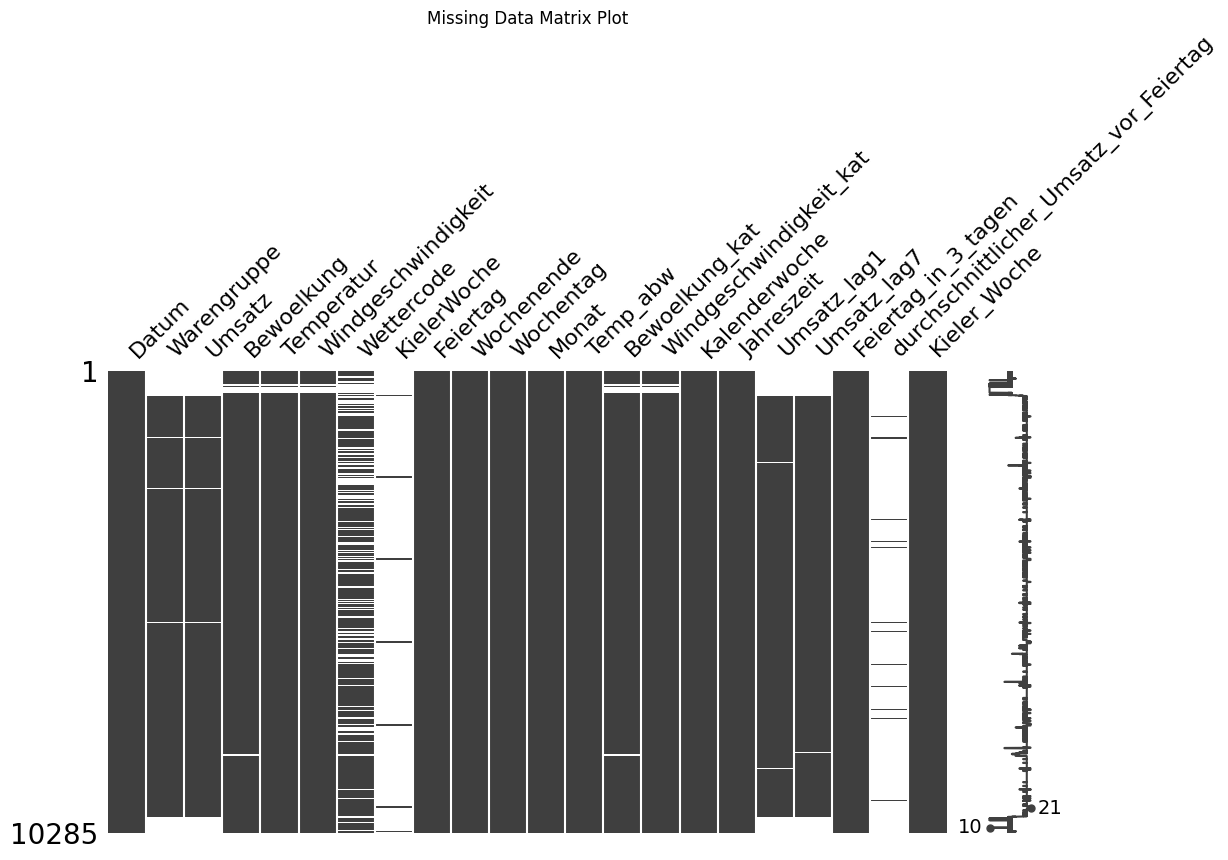

In [23]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from fancyimpute import IterativeImputer, KNN

# Matrix plot of missing data
msno.matrix(merged_data, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()

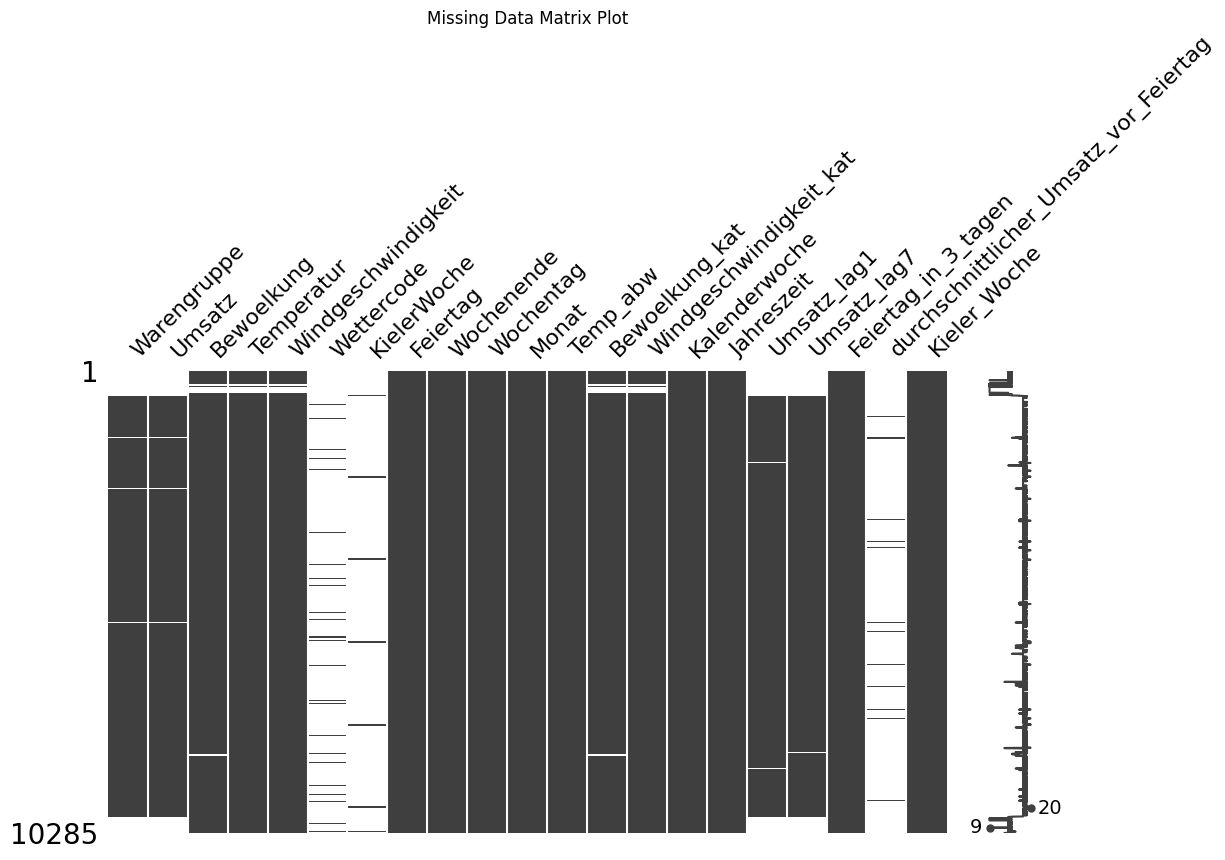

TypeError: 'Categorical' with dtype category does not support reduction 'mean'

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from fancyimpute import IterativeImputer, KNN

# Fehlende Daten visualisieren
msno.matrix(merged_data, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()

# 1. Mittelwert-Imputation
mean_imputed = merged_data.fillna(merged_data.mean())

# 2. Median-Imputation
median_imputed = merged_data.fillna(merged_data.median())

# 3. Interpolation
interpolated = merged_data.interpolate()

# 4. KNN-Imputation
knn_imputer = KNN()
knn_imputed = pd.DataFrame(knn_imputer.fit_transform(merged_data), columns=merged_data.columns)

# 5. Iterative Imputation
iterative_imputer = IterativeImputer()
iterative_imputed = pd.DataFrame(iterative_imputer.fit_transform(merged_data), columns=merged_data.columns)

# Ergebnisse anzeigen
print("Mean Imputation:\n", mean_imputed)
print("\nMedian Imputation:\n", median_imputed)
print("\nInterpolation:\n", interpolated)
print("\nKNN Imputation:\n", knn_imputed)
print("\nIterative Imputation:\n", iterative_imputed)


## Imputation Wettercode

Imputing row 1/10285 with 1 missing, elapsed time: 3.241
Imputing row 101/10285 with 1 missing, elapsed time: 3.242
Imputing row 201/10285 with 1 missing, elapsed time: 3.243
Imputing row 301/10285 with 1 missing, elapsed time: 3.243
Imputing row 401/10285 with 1 missing, elapsed time: 3.244
Imputing row 501/10285 with 1 missing, elapsed time: 3.245
Imputing row 601/10285 with 1 missing, elapsed time: 3.245
Imputing row 701/10285 with 1 missing, elapsed time: 3.246
Imputing row 801/10285 with 1 missing, elapsed time: 3.247
Imputing row 901/10285 with 1 missing, elapsed time: 3.247
Imputing row 1001/10285 with 0 missing, elapsed time: 3.248
Imputing row 1101/10285 with 1 missing, elapsed time: 3.249
Imputing row 1201/10285 with 1 missing, elapsed time: 3.249
Imputing row 1301/10285 with 1 missing, elapsed time: 3.250
Imputing row 1401/10285 with 1 missing, elapsed time: 3.251
Imputing row 1501/10285 with 1 missing, elapsed time: 3.251
Imputing row 1601/10285 with 1 missing, elapsed time

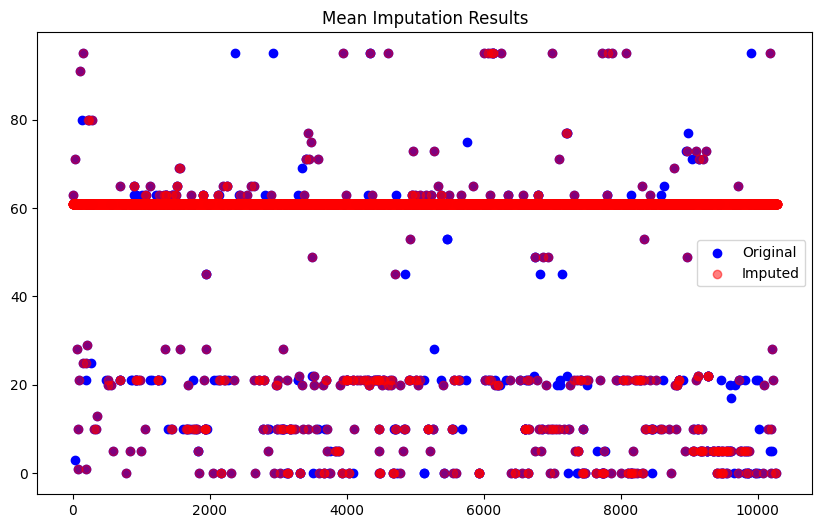

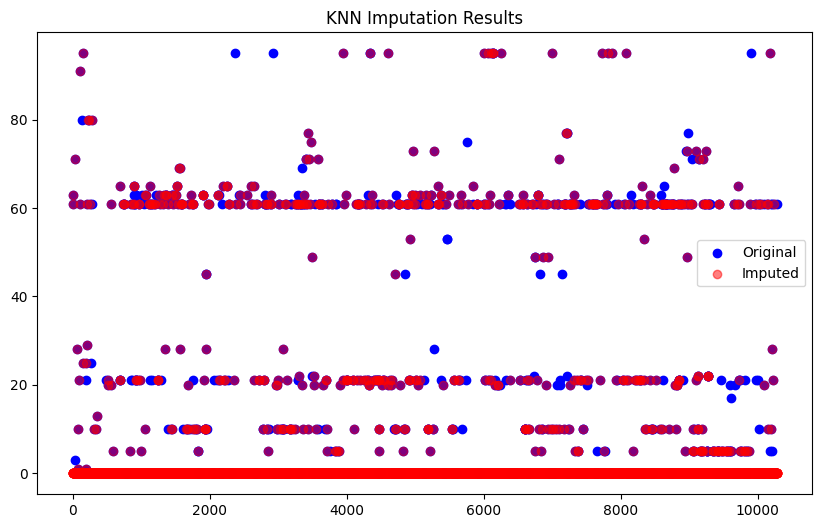

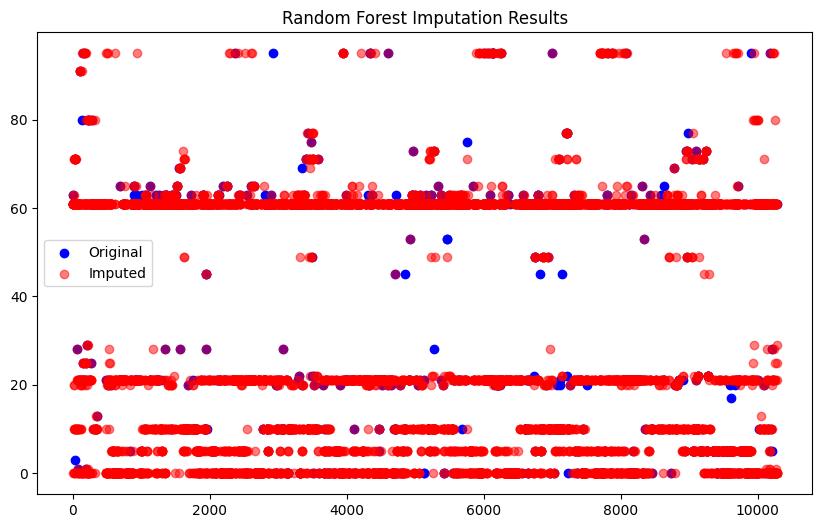

In [40]:
# Checken welche Methode am besten geeignet ist, indem 30% der Werte gelöscht werden
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from fancyimpute import KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt

# Angenommen, merged_data ist Ihr DataFrame
# merged_data = pd.read_csv('your_data.csv')  # Ersetzen Sie dies durch den tatsächlichen Datenladevorgang

# Original-Wettercode speichern
original_wettercode = merged_data['Wettercode'].copy()

# 30% der Werte in Wettercode löschen
nan_fraction = 0.3
n_missing = int(len(merged_data) * nan_fraction)
missing_indices = random.sample(range(len(merged_data)), n_missing)
merged_data.loc[missing_indices, 'Wettercode'] = np.nan

# Angenommen, 'Datum' ist eine Spalte mit Datums- und Zeitwerten
# Entfernen der 'Datum'-Spalte, wenn sie nicht benötigt wird
if 'Datum' in merged_data.columns:
    merged_data = merged_data.drop(columns=['Datum'])

# Funktion zur Berechnung der Accuracy
def calculate_accuracy(original, imputed, missing_indices):
    # Entfernen der NaN-Werte aus den originalen Daten an den missing_indices
    valid_indices = [i for i in missing_indices if not pd.isna(original[i])]
    return accuracy_score(original[valid_indices], imputed[valid_indices])

# 1. Methode: Modustimputation
imputer_mean = SimpleImputer(strategy='most_frequent')
data_mean_imputed = merged_data.copy()
data_mean_imputed['Wettercode'] = imputer_mean.fit_transform(data_mean_imputed[['Wettercode']])

# 2. Methode: KNN-Imputation
imputer_knn = KNN()
data_knn_imputed = merged_data.copy()
data_knn_imputed['Wettercode'] = imputer_knn.fit_transform(data_knn_imputed[['Wettercode']])

# 3. Methode: Random Forest Imputation
train_data = merged_data.dropna(subset=['Wettercode'])
test_data = merged_data[merged_data['Wettercode'].isna()]

clf = RandomForestClassifier()
clf.fit(train_data.drop(columns=['Wettercode']), train_data['Wettercode'])

predictions_rf = clf.predict(test_data.drop(columns=['Wettercode']))

data_rf_imputed = merged_data.copy()
data_rf_imputed.loc[data_rf_imputed['Wettercode'].isna(), 'Wettercode'] = predictions_rf

# Accuracy für jede Methode berechnen
accuracy_mean = calculate_accuracy(original_wettercode, data_mean_imputed['Wettercode'], missing_indices)
accuracy_knn = calculate_accuracy(original_wettercode, data_knn_imputed['Wettercode'], missing_indices)
accuracy_rf = calculate_accuracy(original_wettercode, data_rf_imputed['Wettercode'], missing_indices)

print(f"Accuracy der Mittelwertimputation: {accuracy_mean}")
print(f"Accuracy der KNN-Imputation: {accuracy_knn}")
print(f"Accuracy der Random Forest Imputation: {accuracy_rf}")

# Ergebnis visualisieren
def plot_imputation_results(original, imputed, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(original)), original, color='blue', label='Original')
    plt.scatter(range(len(imputed)), imputed, color='red', alpha=0.5, label='Imputed')
    plt.title(title)
    plt.legend()
    plt.show()

plot_imputation_results(original_wettercode, data_mean_imputed['Wettercode'], 'Mean Imputation Results')
plot_imputation_results(original_wettercode, data_knn_imputed['Wettercode'], 'KNN Imputation Results')
plot_imputation_results(original_wettercode, data_rf_imputed['Wettercode'], 'Random Forest Imputation Results')


In [ ]:
# Create a mask for the imputed values
mask = merged_data['Wettercode'].isna()  # mask for missing values in 'Ozone'

In [ ]:
# Entferne die Datumsfelder
data_no_dates = merged_data.drop(columns=['Datum'])

# KNN-Imputation durchführen
imputer_knn = KNN()
imputed_data_KNN = pd.DataFrame(imputer_knn.fit_transform(data_no_dates), columns=data_no_dates.columns)

# Füge die Datumsfelder wieder hinzu
imputed_data_KNN['Datum'] = merged_data['Datum'].values

Imputing row 1/10285 with 6 missing, elapsed time: 18.896
Imputing row 101/10285 with 6 missing, elapsed time: 18.929
Imputing row 201/10285 with 6 missing, elapsed time: 18.965
Imputing row 301/10285 with 12 missing, elapsed time: 18.986
Imputing row 401/10285 with 12 missing, elapsed time: 19.014
Imputing row 501/10285 with 6 missing, elapsed time: 19.046
Imputing row 601/10285 with 2 missing, elapsed time: 19.058
Imputing row 701/10285 with 3 missing, elapsed time: 19.067
Imputing row 801/10285 with 3 missing, elapsed time: 19.074
Imputing row 901/10285 with 2 missing, elapsed time: 19.081
Imputing row 1001/10285 with 2 missing, elapsed time: 19.088
Imputing row 1101/10285 with 2 missing, elapsed time: 19.095
Imputing row 1201/10285 with 2 missing, elapsed time: 19.101
Imputing row 1301/10285 with 3 missing, elapsed time: 19.108
Imputing row 1401/10285 with 2 missing, elapsed time: 19.115
Imputing row 1501/10285 with 2 missing, elapsed time: 19.121
Imputing row 1601/10285 with 2 mis

In [ ]:
# Iterative Robust Model Imputation (IRMI)
imputer_irmi = IterativeImputer()
imputed_data_irmi = pd.DataFrame(imputer_irmi.fit_transform(data_no_dates), columns=data_no_dates.columns)

# Füge die Datumsfelder wieder hinzu
imputed_data_irmi['Datum'] = merged_data['Datum'].values

/home/codespace/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Beispiel: Vorhersage mit RandomForest
train_data = data_no_dates.dropna(subset=['Wettercode'])
test_data = data_no_dates[data_no_dates['Wettercode'].isna()]

clf = RandomForestClassifier()
clf.fit(train_data.drop(columns=['Wettercode']), train_data['Wettercode'])

# Hier wird data_no_dates mit den predicitions aufgefüllt (siehe Plot unten)
predictions = clf.predict(test_data.drop(columns=['Wettercode']))
data_no_dates.loc[data_no_dates['Wettercode'].isna(), 'Wettercode'] = predictions

In [ ]:
# Define a function for scatter plots that highlights imputed values
def plot_scatter_with_imputation(data, x, y, mask, title='Scatter Plot', xlabel='X-axis', ylabel='Y-axis'):
    plt.figure(figsize=(10, 6))
    # Plot non-imputed points
    sns.scatterplot(x=data.loc[~mask, x], y=data.loc[~mask, y], color='blue', label='Original')
    # Plot imputed points
    sns.scatterplot(x=data.loc[mask, x], y=data.loc[mask, y], color='red', label='Imputed')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

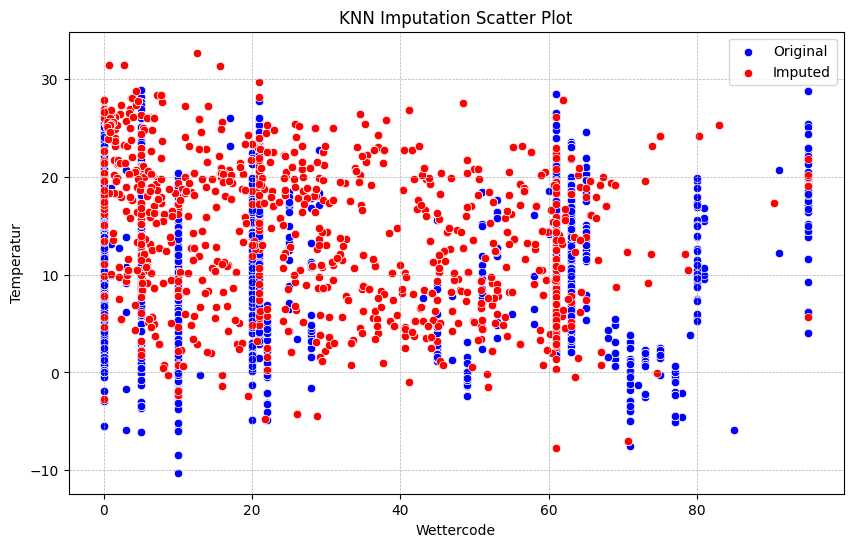

In [ ]:
# Plotting results for KNN imputation
plot_scatter_with_imputation(imputed_data_KNN, 'Wettercode', 'Temperatur', mask, 'KNN Imputation Scatter Plot', 'Wettercode', 'Temperatur')

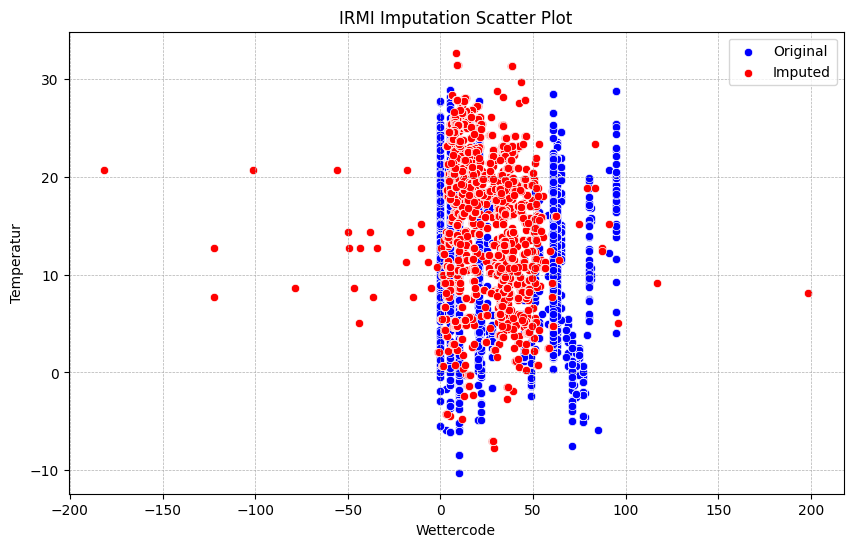

In [ ]:
# Plotting results for IRMI imputation
plot_scatter_with_imputation(imputed_data_irmi, 'Wettercode', 'Temperatur', mask, 'IRMI Imputation Scatter Plot', 'Wettercode', 'Temperatur')

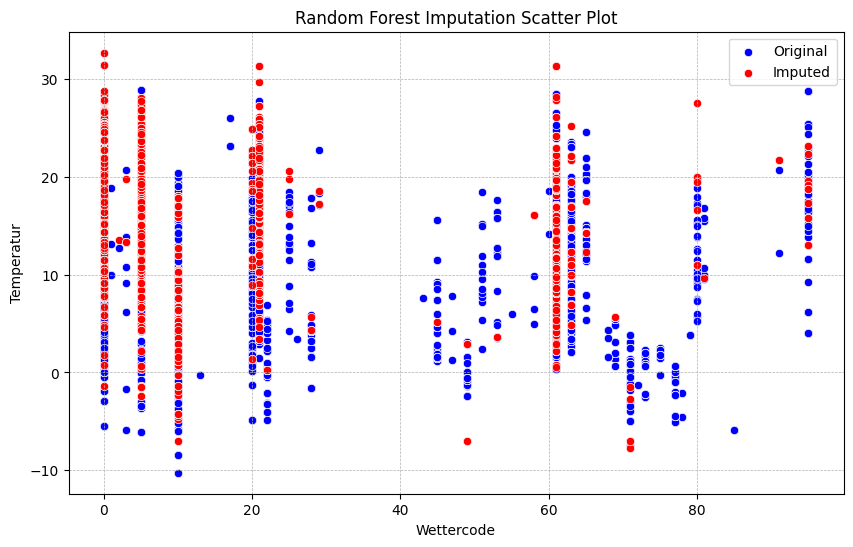

In [ ]:
plot_scatter_with_imputation(data_no_dates, 'Wettercode', 'Temperatur', mask, 'Random Forest Imputation Scatter Plot', 'Wettercode', 'Temperatur')

In [ ]:
print("Correlation in original data:", merged_data['Wettercode'].corr(merged_data['Temperatur'], method='pearson'))
print("Correlation after KNN imputation:", imputed_data_KNN['Wettercode'].corr(imputed_data_KNN['Temperatur']))
print("Correlation after IRMI:", imputed_data_irmi['Wettercode'].corr(imputed_data_irmi['Temperatur']))
print("Correlation after RF imputation:", data_no_dates['Wettercode'].corr(data_no_dates['Temperatur']))

Correlation in original data: -0.08331109308021045
Correlation after KNN imputation: -0.15984325790618867
Correlation after IRMI: -0.1624487780818261
Correlation after RF imputation: -0.19396844055299423


## Korrelationen

In [ ]:
# Korrelationsmatrix für Wettercode imputierte Daten (RF-Imputation) ohne Datum
print(data_no_dates.corr())

# Korrelationsmatrix für nicht imputierte Daten mit Datum
print(merged_data.corr())


                                        Warengruppe    Umsatz  Bewoelkung  \
Warengruppe                                1.000000 -0.062589    0.023795   
Umsatz                                    -0.062589  1.000000   -0.089916   
Bewoelkung                                 0.023795 -0.089916    1.000000   
Temperatur                                -0.047015  0.222935   -0.383888   
Windgeschwindigkeit                       -0.009078  0.014705    0.042813   
Wettercode                                 0.016509 -0.042938    0.612985   
KielerWoche                                     NaN       NaN         NaN   
Feiertag                                  -0.006163  0.043574   -0.031793   
Wochenende                                 0.000457  0.163097   -0.006312   
Wochentag                                  0.000560  0.136199   -0.005812   
Monat                                      0.080817  0.013889    0.032380   
Temp_abw                                  -0.000134 -0.007693   -0.099163   

## Datensätze speichern

In [ ]:
# Datensätze speichern
merged_data.to_csv('0_DataPreparation/merged_data.csv', index=False)
imputed_data_KNN.to_csv('0_DataPreparation/imputed_data_KNN.csv', index=False)
imputed_data_irmi.to_csv('0_DataPreparation/imputed_data_irmi.csv', index=False)
data_no_dates.to_csv('0_DataPreparation/imputed_data_RF.csv', index=False)

## Neuronales Netz probieren

In [ ]:
data_wna = merged_data.dropna()
print(data_wna)

# Ich habe ein Problem, weil ich durch das feature engineering zu viele NaNs habe. Ich werde das Feature Engineering nochmal durchgehen und schauen, ob ich das Problem lösen kann.


Empty DataFrame
Columns: [Datum, Warengruppe, Umsatz, Bewoelkung, Temperatur, Windgeschwindigkeit, Wettercode, KielerWoche, Feiertag, Wochenende, Wochentag, Monat, Temp_abw, Bewoelkung_kat, Windgeschwindigkeit_kat, Kalenderwoche, Jahreszeit, Umsatz_lag1, Umsatz_lag7, Feiertag_in_3_tagen, durchschnittlicher_Umsatz_vor_Feiertag, Kieler_Woche]
Index: []

[0 rows x 22 columns]


In [ ]:
import os
import pandas as pd

# Daten mit Zeitreihenstruktur aufteilen
# Ensure the data is sorted by date
data = merged_data.sort_values(by='Datum').dropna()
print(merged_data.head())

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

# Split the data based on the date thresholds
train_data = data[data['Datum'] <= train_end_date]
validation_data = data[(data['Datum'] > train_end_date) & (data['Datum'] <= validation_end_date)]
test_data = data[data['Datum'] > validation_end_date]

# Check the dimensions of the datasets
print("Training dataset dimensions:", train_data.shape)
print("Validation dataset dimensions:", validation_data.shape)
print("Test dataset dimensions:", test_data.shape)

# Define the file paths
subdirectory = "pickle_data"
if not os.path.exists(subdirectory):
    os.makedirs(subdirectory)

training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Assuming 'Umsatz' is the label and the rest are features
train_features = train_data.drop(columns=['Umsatz'])
train_labels = train_data['Umsatz']
validation_features = validation_data.drop(columns=['Umsatz'])
validation_labels = validation_data['Umsatz']
test_features = test_data.drop(columns=['Umsatz'])
test_labels = test_data['Umsatz']

# Save the datasets to pickle files
train_features.to_pickle(training_features_path)
train_labels.to_pickle(training_labels_path)
validation_features.to_pickle(validation_features_path)
validation_labels.to_pickle(validation_labels_path)
test_features.to_pickle(test_features_path)
test_labels.to_pickle(test_labels_path)

# Verify the saved data by reading the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())

       Datum  Warengruppe  Umsatz  Bewoelkung  Temperatur  \
0 2012-01-01          NaN     NaN         8.0      9.8250   
1 2012-01-02          NaN     NaN         7.0      7.4375   
2 2012-01-03          NaN     NaN         8.0      5.5375   
3 2012-01-04          NaN     NaN         4.0      5.6875   
4 2012-01-05          NaN     NaN         6.0      5.3000   

   Windgeschwindigkeit  Wettercode  KielerWoche  Feiertag  Wochenende  ...  \
0                 14.0        58.0          NaN         1        True  ...   
1                 12.0         NaN          NaN         0       False  ...   
2                 18.0        63.0          NaN         0       False  ...   
3                 19.0        80.0          NaN         0       False  ...   
4                 23.0        80.0          NaN         0       False  ...   

   Temp_abw  Bewoelkung_kat  Windgeschwindigkeit_kat Kalenderwoche Jahreszeit  \
0      True               2                        2            52          1   
1 

In [ ]:
# Convert DataFrames to numpy arrays
training_features_array = training_features.to_numpy()
training_labels_array = training_labels.to_numpy().flatten()  # Flatten in case labels are a DataFrame with one column

print("Training Features Array:")
print(training_features_array[:5])

Training Features Array:
[]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
  InputLayer(input_shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(10, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1)
])

model.summary()


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_15          │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353 (1.38 KB)

 Trainable params: 311 (1.21 KB)

 Non-trainable params: 42 (168.00 B)

In [ ]:
# Entferne die Spalten mit dem Datentyp `datetime64[ns]`
training_features = training_features.select_dtypes(exclude=['datetime'])
validation_features = validation_features.select_dtypes(exclude=['datetime'])
test_features = test_features.select_dtypes(exclude=['datetime'])

# Stellen Sie sicher, dass die Daten vorbereitet sind
# Überprüfen Sie die Anzahl der Merkmale
print("Training features shape:", training_features.shape)

# Beispiel für die Erstellung eines einfachen neuronalen Netzwerks
# InputLayer an die Anzahl der Merkmale anpassen
model = Sequential([
    InputLayer(input_shape=(training_features.shape[1],)),  # Anzahl der Merkmale dynamisch anpassen
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1)  # Ausgabe-Neuron für die Regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Modell trainieren
history = model.fit(training_features, training_labels, epochs=2,
                    validation_data=(validation_features, validation_labels))


Training features shape: (0, 20)
Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-06-14 10:06:38.078317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/codespace/.python/current/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


TypeError: 'NoneType' object is not iterable

In [ ]:
model.save("python_model.h5")

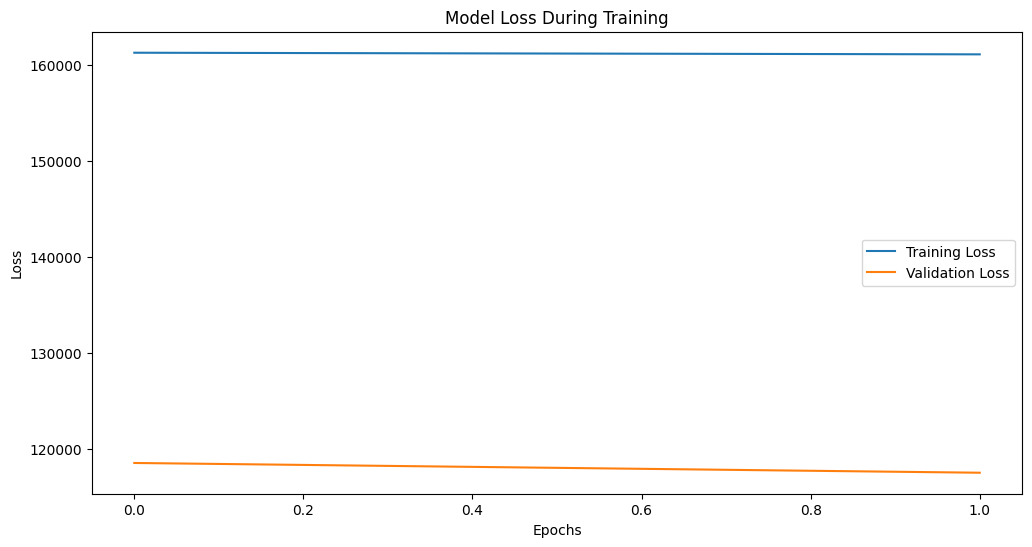

In [ ]:
# Training history plotten
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predictions machen
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAPE on the Training Data: 104.84%
MAPE on the Validation Data: 104.87%


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


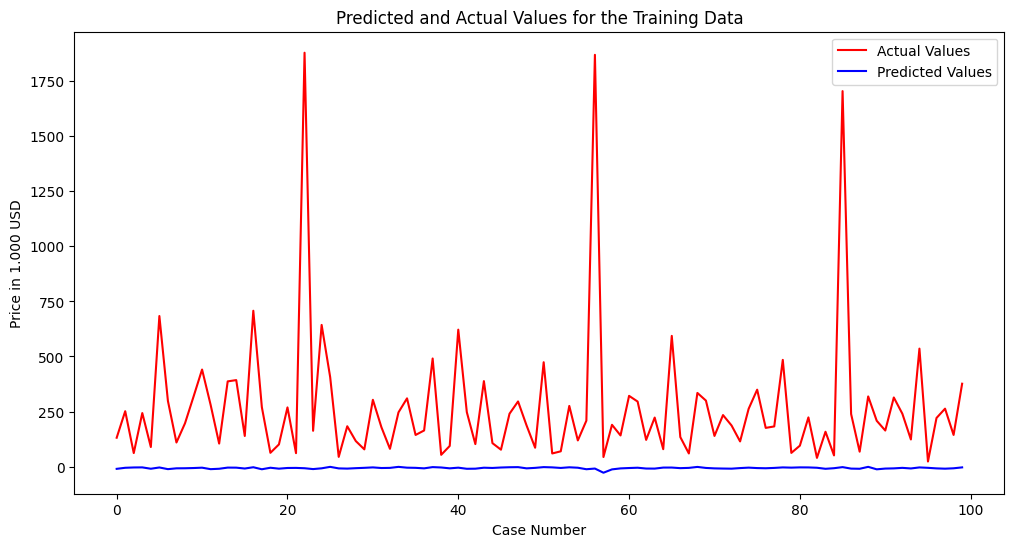

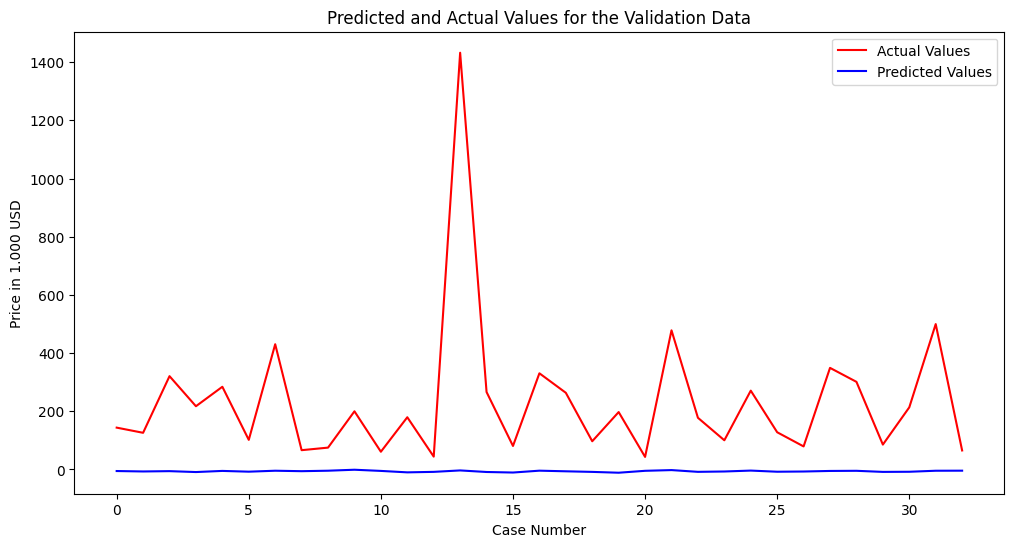

In [ ]:
# Plotten
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Price in 1.000 USD')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')